## Data loading

We load the libraries and dataset that can be found in https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.Planetoid.html#torch_geometric.datasets.Planetoid

In [2]:
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import RandomNodeSplit

dataset = Planetoid(root='../data/citation', name='Cora')

print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Number of graphs: 1
Number of features: 1433
Number of classes: 7


Processing...
Done!


In [3]:
data = dataset[0]
labels = data.y
features = data.x
edges = data.edge_index

# Genero matriz de adyacencia
G = torch.zeros(data.num_nodes, data.num_nodes)
G[edges[0], edges[1]] = 1
G[edges[1], edges[0]] = 1

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(data)

Number of nodes: 2708
Number of edges: 10556
Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])


In [4]:
unique_labels, counts = np.unique(labels, return_counts=True)
percentages = (counts / counts.sum()) * 100

for label, percentage in zip(unique_labels, percentages):
    print(f"Label: {label}, Percentage: {percentage:.2f}%")

Label: 0, Percentage: 12.96%
Label: 1, Percentage: 8.01%
Label: 2, Percentage: 15.44%
Label: 3, Percentage: 30.21%
Label: 4, Percentage: 15.73%
Label: 5, Percentage: 11.00%
Label: 6, Percentage: 6.65%


We separate into training, validation, and test sets while maintaining the original balance between classes. In addition to the features of each node contained in the dataset, we add its adjacency vector as features. In this way, we have certain information about the structure of the graph.

In [5]:
from sklearn.model_selection import train_test_split

X = torch.cat((G, features), dim=1)
X_numpy, labels_numpy = X.numpy(), labels.numpy()
X_df = pd.DataFrame(X_numpy)

X_dev, X_test, y_dev, y_test  = train_test_split(X_df, labels_numpy, stratify=labels_numpy, test_size=0.25, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, stratify=y_dev, test_size=0.25, random_state=1)

print(X_train.shape, X_val.shape, X_test.shape)

(1523, 4141) (508, 4141) (677, 4141)


We apply PCA to speed up training, reducing the original number of features for each node to 100. We still maintain the adjacency vectors of the nodes as features. However, by applying DeepWalk, we can then get rid of these vectors and use the node embeddings instead. This further reduces the number of features in the model.

In [6]:
from sklearn.decomposition import PCA

n_components = 100
pca = PCA(n_components=n_components)

features_train_pca = pca.fit_transform(X_train.iloc[:, len(G):])
features_val_pca = pca.transform(X_val.iloc[:, len(G):])
features_test_pca = pca.transform(X_test.iloc[:, len(G):])

X_train_pca = np.concatenate((X_train.iloc[:, :len(G)], features_train_pca), axis=1)
X_val_pca = np.concatenate((X_val.iloc[:, :len(G)], features_val_pca), axis=1)
X_test_pca = np.concatenate((X_test.iloc[:, :len(G)], features_test_pca), axis=1)

print(X_train_pca.shape, X_val_pca.shape, X_test_pca.shape)

(1523, 2808) (508, 2808) (677, 2808)


## Deepwalk

To implement the algorithm, we create a class that handles generating random walks for each node in the graph.

On the other hand, we have a class that simply applies skipgram (from the gensim library) to the generated walks, which allows us to obtain a matrix with the embeddings of each node. In this context, the random walks play the role of "sentences" needed to train the skipgram.

In [ ]:
import sys
sys.path.append("..") 
from src.deep_walk import DeepWalk

G_numpy = G.numpy()
dw = DeepWalk(G_numpy, walk_length=10, num_walks=100)
dw.train(window_size=5, iters=5)
embeddings = dw.get_embeddings()

Generating sentences...


100%|██████████| 100/100 [02:10<00:00,  1.30s/it]



Training skipgram...

Done!


## Nodes classification with logistic regression

### No embeddings

In a first instance, we apply a logistic regression model that does not use node embeddings as features, but simply uses their adjacency vector (along with the original features that we transformed with PCA).

To try to avoid overfitting, we apply some regularization to the model.

In [ ]:
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression

res_df = pd.DataFrame(columns=['Train_score', 'Val_score', 'C'])
C_vals = [1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1]

for i,C in enumerate(C_vals):
  log_reg = LogisticRegression(C=C, random_state=42)
  log_reg.fit(X_train_pca, y_train)

  y_train_pred = log_reg.predict(X_train_pca)
  y_val_pred = log_reg.predict(X_val_pca)

  train_f1 = f1_score(y_train, y_train_pred, average='weighted')
  val_f1 = f1_score(y_val, y_val_pred, average='weighted')
  res_df.loc[i] = [train_f1, val_f1, C]

res_df.sort_values(by='Val_score', ascending=False, inplace=True)

In [ ]:
res_df.head()

,Train_score,Val_score,C
5,0.984912,0.773570,1.0000
4,0.960632,0.769422,0.5000
3,0.884136,0.722273,0.1000
2,0.631930,0.542315,0.0100
0,0.140127,0.139427,0.0001


We take C = 0.1 as the regularization coefficient. Despite there being a fairly considerable difference between the score obtained in training and validation, for smaller values, equivalent to greater regularization, the results are quite poor.

weighted f1-score en test: 0.776990372073857
              precision    recall  f1-score   support

           0       0.65      0.66      0.66        88
           1       0.89      0.74      0.81        54
           2       0.95      0.80      0.87       105
           3       0.72      0.93      0.81       205
           4       0.80      0.75      0.77       106
           5       0.77      0.69      0.73        74
           6       0.93      0.56      0.69        45

    accuracy                           0.78       677
   macro avg       0.82      0.73      0.76       677
weighted avg       0.79      0.78      0.78       677



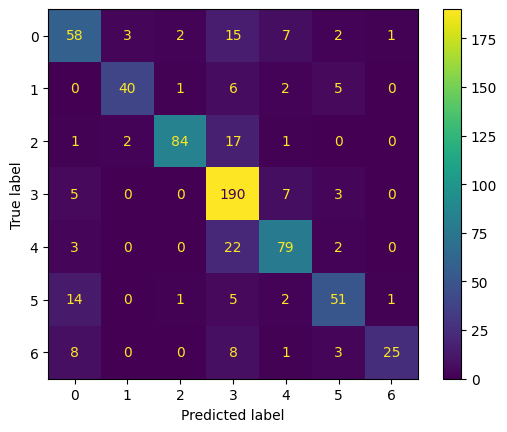

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix,ConfusionMatrixDisplay

model = LogisticRegression(C=0.1, random_state=42)
model.fit(X_train_pca, y_train)
y_pred = model.predict(X_test_pca)


conf_mat = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)

print("weighted f1-score en test:", f1_score(y_test, y_pred, average='weighted'))
print(classification_report(y_test, y_pred))
disp.plot()

### With embeddings

Now let's see if generating embeddings through DeepWalk can improve the results previously obtained. To choose DeepWalk hyperparameters such as the number of walks per node, their length, and the number of components in the embedding vectors, we use the validation dataset.

To simplify the task, we fix certain hyperparameters such as the number of epochs and the window size.

In [ ]:
# Parametros para DeepWalk
params_dw = {'walk_length': [10, 20, 40],
             'num_walks': [25, 50, 100],
             'embedding_size': [64, 128, 256]
            }

res_df_deepwalk = pd.DataFrame(columns=['Train_score', 'Val_score', 'walk_length', 'num_walks', 'embedding_size'])

i = 0
for walk_length in params_dw['walk_length']:
  random_walker = RandomWalker(G_numpy, walk_length)

  for n_walks in params_dw['num_walks']:
    sentences = random_walker.generate_walks(n_walks)

    for dim in params_dw['embedding_size']:
      dw = DeepWalk(G_numpy, walk_length=walk_length, num_walks=n_walks, sentences=sentences, seed=1)
      dw.train(embedding_size=dim, verbose=0)
      embeddings = dw.get_embeddings()

      X_train_emb = np.concatenate((embeddings[X_train.index], features_train_pca), axis=1)
      X_val_emb = np.concatenate((embeddings[X_val.index], features_val_pca), axis=1)

      model = LogisticRegression(C=0.1, random_state=42)
      model.fit(X_train_emb, y_train)

      y_train_pred = model.predict(X_train_emb)
      y_val_pred = model.predict(X_val_emb)

      train_f1 = f1_score(y_train, y_train_pred, average='weighted')
      val_f1 = f1_score(y_val, y_val_pred, average='weighted')

      res_df_deepwalk.loc[i] = [train_f1, val_f1, walk_length, n_walks, dim]
      i += 1

res_df_deepwalk.sort_values(by='Val_score', ascending=False, inplace=True)

100%|██████████| 100/100 [05:38<00:00,  3.39s/it]


In [ ]:
res_df_deepwalk.head()

,Train_score,Val_score,walk_length,num_walks,embedding_size
13,0.927615,0.854132,20.0,50.0,128.0
11,0.944710,0.848264,20.0,25.0,256.0
26,0.945391,0.847759,40.0,100.0,256.0
16,0.929065,0.846470,20.0,100.0,128.0
8,0.938868,0.846208,10.0,100.0,256.0


The results seem to improve quite a bit. Additionally, the gap between validation and training is smaller.

In [ ]:
res_df_deepwalk.tail()

,Train_score,Val_score,walk_length,num_walks,embedding_size
15,0.910670,0.826487,20.0,100.0,64.0
21,0.900830,0.825556,40.0,50.0,64.0
24,0.907397,0.824316,40.0,100.0,64.0
12,0.900143,0.824064,20.0,50.0,64.0
6,0.914397,0.823615,10.0,100.0,64.0


The worst results are still better than those obtained without using embeddings. The most determining parameter seems to be the embedding size - when it's only 64, the results aren't as good.

Let's see how a model trained with embeddings generated from DeepWalk performs on the test data using the best combination of hyperparameters found.

Generating sentences...


100%|██████████| 50/50 [01:18<00:00,  1.58s/it]



Training skipgram...

Done!
weighted f1-score en test: 0.8610542597835196
              precision    recall  f1-score   support

           0       0.75      0.77      0.76        88
           1       0.89      0.87      0.88        54
           2       0.95      0.90      0.93       105
           3       0.85      0.92      0.88       205
           4       0.86      0.87      0.86       106
           5       0.87      0.80      0.83        74
           6       0.92      0.76      0.83        45

    accuracy                           0.86       677
   macro avg       0.87      0.84      0.85       677
weighted avg       0.86      0.86      0.86       677



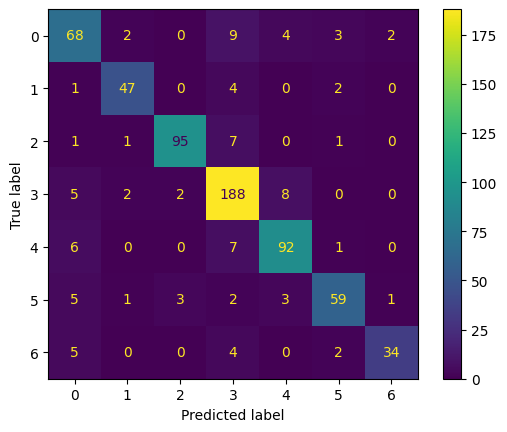

In [ ]:
# Train DeepWalk with chosen hyperparameters
walk_length = res_df_deepwalk.iloc[0]['walk_length'].astype(int)
num_walks = res_df_deepwalk.iloc[0]['num_walks'].astype(int)
embedding_size = res_df_deepwalk.iloc[0]['embedding_size'].astype(int)

deep_walk = DeepWalk(G_numpy, walk_length=walk_length, num_walks=num_walks, seed=1)
deep_walk.train(embedding_size=embedding_size)
embeddings = deep_walk.get_embeddings()

# Generate training and testing dataset with embedded nodes
X_train_emb = np.concatenate((embeddings[X_train.index], features_train_pca), axis=1)
X_test_emb = np.concatenate((embeddings[X_test.index], features_test_pca), axis=1)

# Train logistic regression model
model = LogisticRegression(C=0.1, random_state=42)
model.fit(X_train_emb, y_train)
preds = model.predict(X_test_emb)

# Evaluate model
conf_mat = confusion_matrix(y_test, preds)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)

print("weighted f1-score en test:", f1_score(y_test, preds, average='weighted'))
print(classification_report(y_test, preds))
disp.plot()

Finally, let's use t-SNE to visualize the embeddings generated by DeepWalk in 2-D

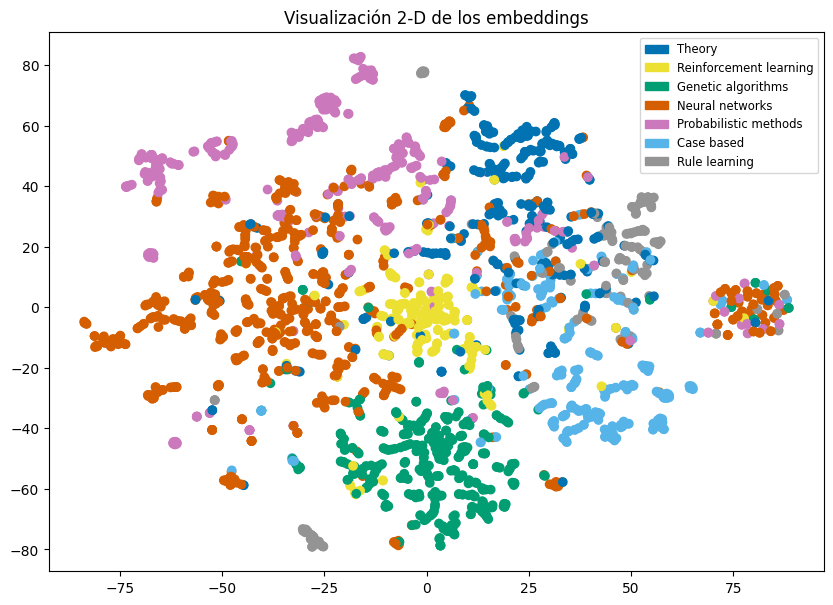

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42, perplexity=15)
embeddings_2d = tsne.fit_transform(embeddings)

label_dict = {0: "Theory",
              1: "Reinforcement learning",
              2: "Genetic algorithms",
              3: "Neural networks",
              4: "Probabilistic methods",
              5: "Case based",
              6: "Rule learning"
             }

palette = sns.color_palette('colorblind')
topics_colors = {"Theory": palette[0],
                "Reinforcement learning": palette[8],
                "Genetic algorithms": palette[2],
                "Neural networks": palette[3],
                "Probabilistic methods": palette[4],
                "Case based": palette[9],
                "Rule learning": palette[7]
              }
colors = [topics_colors[label_dict[label]] for label in labels_numpy]

fig, ax = plt.subplots(figsize=(10, 7))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors)
patches = [mpatches.Patch(color=color, label=topic) for topic, color in topics_colors.items()]
ax.legend(handles=patches, fontsize='small', loc='best')

plt.title('Visualización 2-D de los embeddings')
plt.show()